In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [18]:
# Load the data
data = pd.read_csv('https://raw.githubusercontent.com/sbkowshik/energy-consumption-prediction/main/Household_electricity_dataset.csv')

# Separate features and target
X = data.drop(columns=["Value"])
X = data.drop(columns=["Date"])
y = data["Value"]

# Standardize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [19]:
class AttentionLayer(layers.Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.W = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, features):
        score = tf.nn.tanh(self.W(features))
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector


In [25]:

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
n_features = X.shape[1]  # Number of features
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [28]:
def create_lstm_attention_model(input_shape):
    inputs = layers.Input(shape=input_shape)
    lstm = layers.LSTM(64, return_sequences=True)(inputs)
    attention = AttentionLayer(64)(lstm)
    outputs = layers.Dense(1)(attention)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# Create the model
model = create_lstm_attention_model(input_shape=(X_train.shape[1], X_train.shape[2]))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1, 20)]           0         
                                                                 
 lstm_5 (LSTM)               (None, 1, 64)             21760     
                                                                 
 attention_layer_1 (Attenti  (None, 64)                4225      
 onLayer)                                                        
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 26050 (101.76 KB)
Trainable params: 26050 (101.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
history=model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/200
38/38 [==============================] - 5s 20ms/step - loss: 553.3009 - val_loss: 584.7443
Epoch 2/200
38/38 [==============================] - 0s 5ms/step - loss: 452.7984 - val_loss: 455.2933
Epoch 3/200
38/38 [==============================] - 0s 4ms/step - loss: 335.3372 - val_loss: 338.5011
Epoch 4/200
38/38 [==============================] - 0s 5ms/step - loss: 247.9188 - val_loss: 263.5036
Epoch 5/200
38/38 [==============================] - 0s 5ms/step - loss: 196.8535 - val_loss: 218.8367
Epoch 6/200
38/38 [==============================] - 0s 5ms/step - loss: 168.6533 - val_loss: 194.5410
Epoch 7/200
38/38 [==============================] - 0s 6ms/step - loss: 154.0374 - val_loss: 180.1114
Epoch 8/200
38/38 [==============================] - 0s 5ms/step - loss: 145.9832 - val_loss: 172.3799
Epoch 9/200
38/38 [==============================] - 0s 5ms/step - loss: 141.7808 - val_loss: 167.0690
Epoch 10/200
38/38 [==============================] - 0s 5ms/step - loss

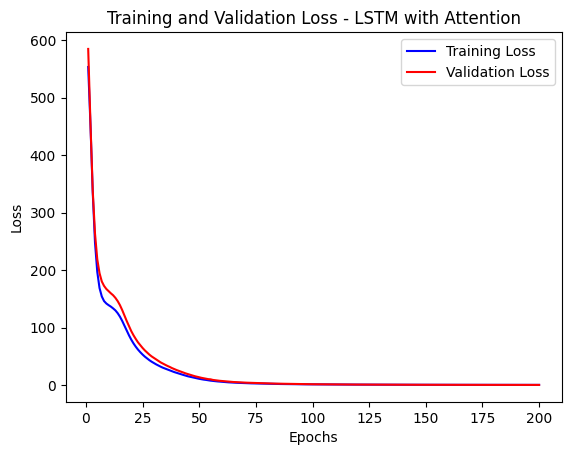

In [30]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss - LSTM with Attention')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Predictions
y_pred = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R2)
r2 = r2_score(y_test, y_pred)
print("R-squared (R2):", r2)

10/10 [==============================] - 1s 3ms/step
Mean Absolute Error (MAE): 0.1669981761925537
Root Mean Squared Error (RMSE): 0.29190335497088327
R-squared (R2): 0.9995215494355679


In [32]:
# Flatten y_test and y_pred arrays
y_test_flattened = y_test.values.flatten()
y_pred_flattened = y_pred.flatten()

# Define a threshold for accuracy (e.g., within +/- 5%)
threshold = 0.05

# Calculate absolute percentage error
absolute_percentage_error = np.abs((y_test_flattened - y_pred_flattened) / y_test_flattened)

# Calculate accuracy based on the threshold
accuracy = np.mean(absolute_percentage_error <= threshold)

print("Accuracy (within +/- 5%):", accuracy)


Accuracy (within +/- 5%): 0.99


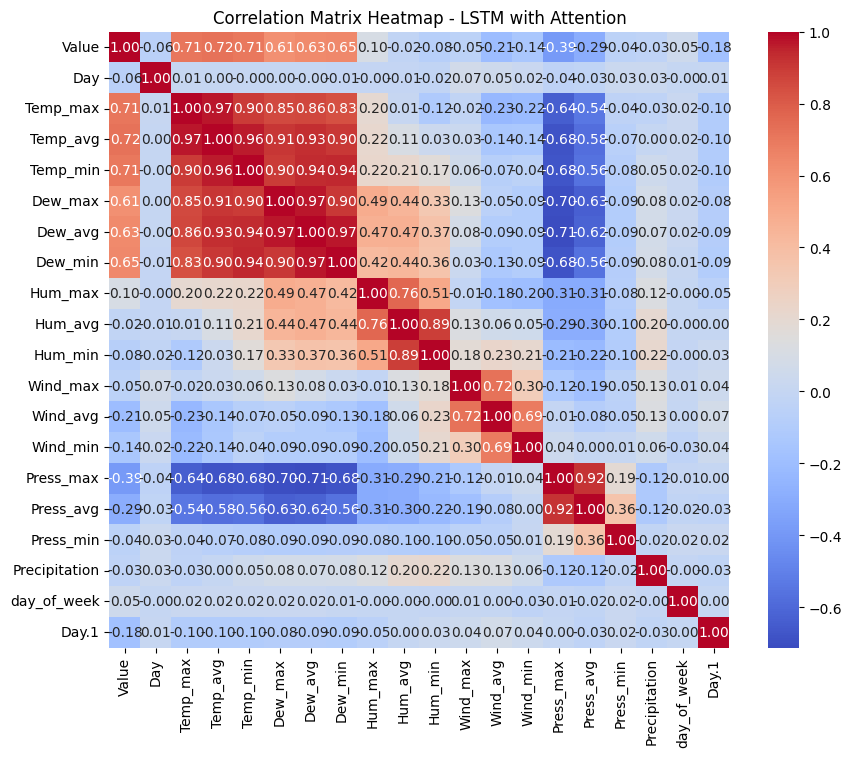

In [33]:
import seaborn as sns

corr_matrix = data.drop(columns=['Date']).corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", annot_kws={"size": 10})
plt.title('Correlation Matrix Heatmap - LSTM with Attention')
plt.show()